In [3]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG19, VGG16
from tensorboard import notebook
from tensorflow import keras 
from tensorflow.keras.applications.resnet import ResNet50
from keras import models, layers
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory
from tensorflow.keras.layers import ( Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout,
    Dense, Lambda, Reshape, Activation, Multiply, Add, UpSampling2D )
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [5]:
from tensorflow.keras.layers import ( Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout,
    Dense, Lambda, Reshape, Activation, Multiply, Add, UpSampling2D )
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


def load_model():


    net = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    x = net.output

    a = UpSampling2D(size=(6, 6))(x)
    a = MaxPooling2D(pool_size=(6, 6))(a)
    a = Conv2D(128, 1, padding='same')(a)

    b = UpSampling2D(size=(4, 4))(x)
    b = MaxPooling2D(pool_size=(4, 4))(b)
    b = Conv2D(128, 1, padding='same')(b)

    c = UpSampling2D(size=(3, 3))(x)
    c = MaxPooling2D(pool_size=(3, 3))(c)
    c = Conv2D(128, 1, padding='same')(c)

    d = UpSampling2D(size=(2, 2))(x)
    d = MaxPooling2D(pool_size=(2, 2))(d)
    d = Conv2D(128, 1, padding='same')(d)

    x =  Concatenate()([a, b, c, d])
    x = Conv2D(256, 1, padding='same')(x)
    x = Conv2D(128, 1, padding='same')(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=net.input, outputs=x)
    
    return model



100%|██████████| 186/186 [00:00<00:00, 195.01it/s]


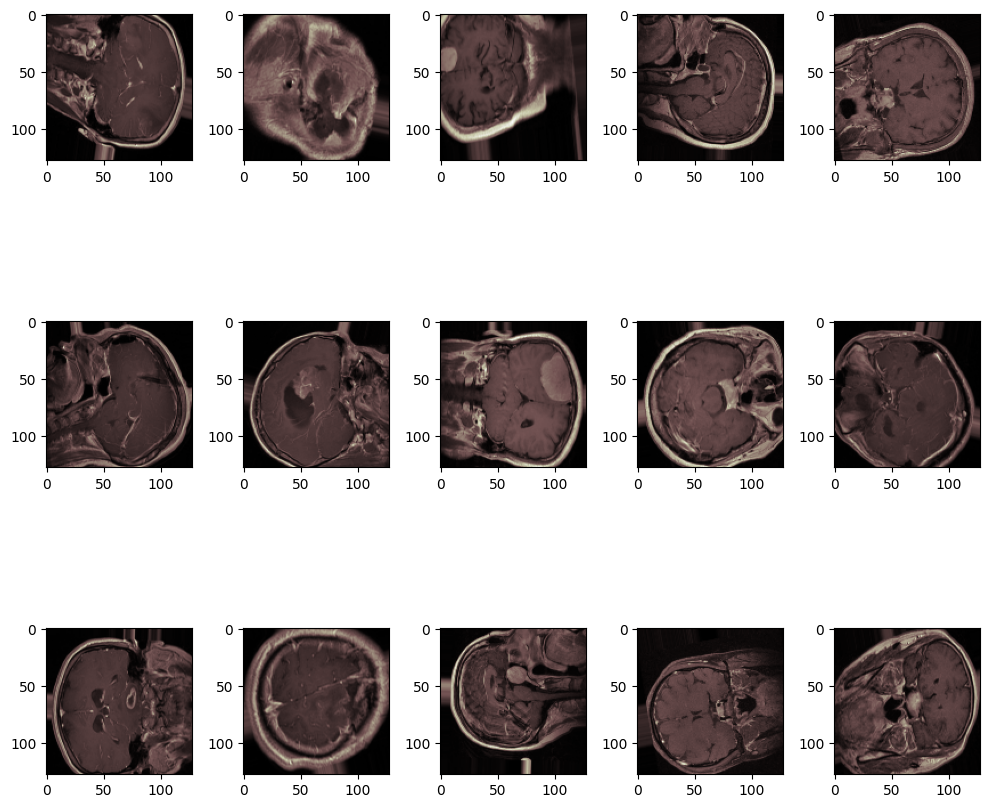

In [4]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 128
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [6]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [7]:
tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-NeuroNet19.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])

Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 1.0373 - accuracy: 0.4240


Epoch 1: saving model to model-NeuroNet19.h5
Epoch 1: 10.68 seconds
264/264 [==============================] - 11s 38ms/step - loss: 1.0369 - accuracy: 0.4244 - val_loss: 0.9608 - val_accuracy: 0.5541 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.7380 - accuracy: 0.6622
Epoch 2: saving model to model-NeuroNet19.h5
Epoch 2: 9.70 seconds
264/264 [==============================] - 10s 37ms/step - loss: 0.7377 - accuracy: 0.6624 - val_loss: 0.6123 - val_accuracy: 0.7713 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.3773 - accuracy: 0.8567
Epoch 3: saving model to model-NeuroNet19.h5
Epoch 3: 9.61 seconds
264/264 [==============================] - 10s 36ms/step - loss: 0.3772 - accuracy: 0.8569 - val_loss: 0.4754 - val_accuracy: 0.8027 - lr: 1.0000e-04
Epoch 4/50
263/264 [============================>.] - ETA: 0s - loss: 0.2357 - accuracy: 0.9072
Epoch 4: saving model to model-NeuroNet19.h5
Epoch 4: 9.70 

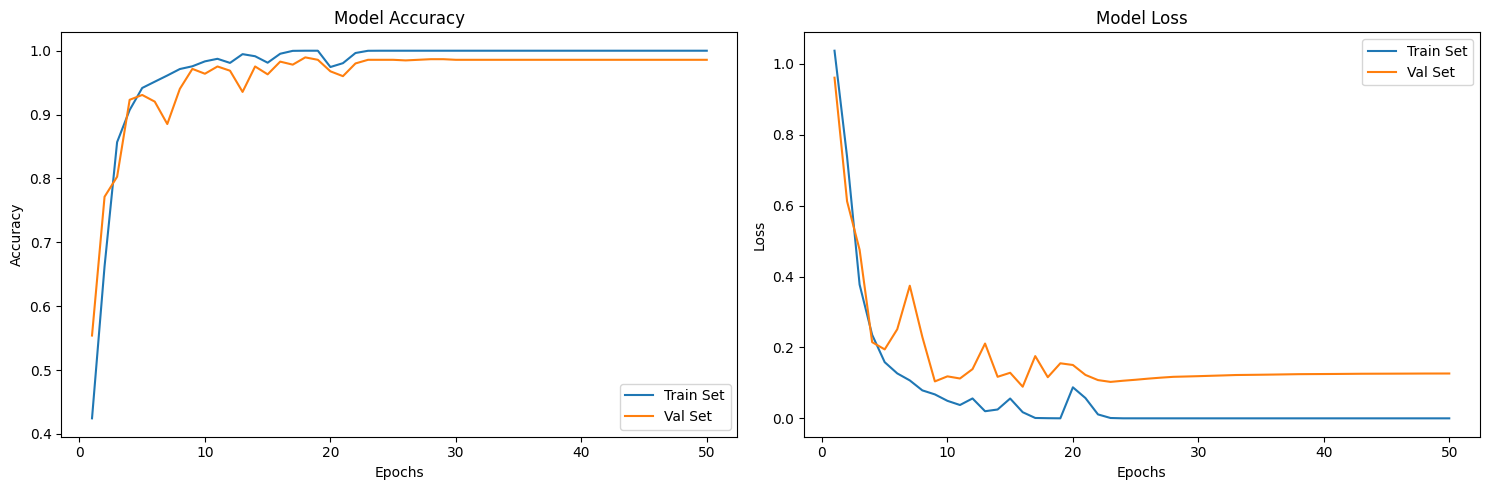

In [8]:
draw_curve(history)

20/20 [==============================] - 0s 10ms/step - loss: 0.2635 - accuracy: 0.9577
Test Accuracy:  95.77
              precision    recall  f1-score   support

      glioma     0.9461    0.9825    0.9640       286
  meningioma     0.9416    0.9085    0.9247       142
   pituitary     0.9889    0.9570    0.9727       186

    accuracy                         0.9577       614
   macro avg     0.9589    0.9493    0.9538       614
weighted avg     0.9580    0.9577    0.9575       614



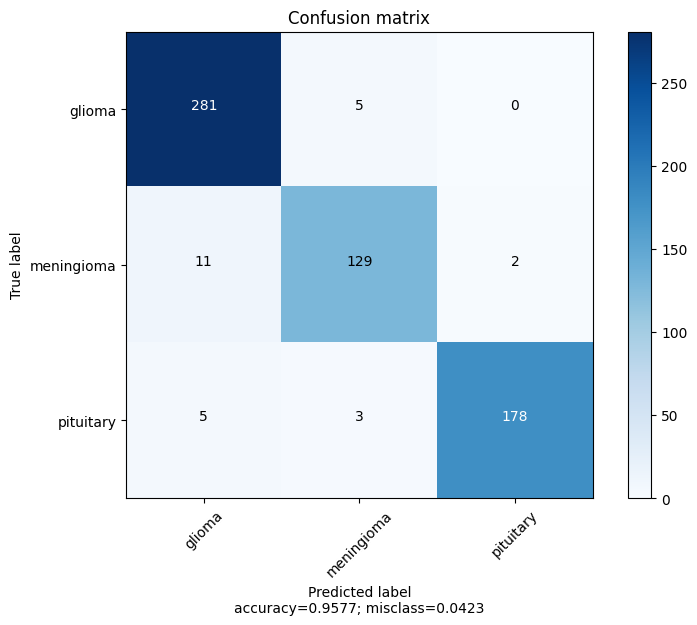

In [9]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

In [18]:
%reset -f

100%|██████████| 186/186 [00:00<00:00, 196.95it/s]


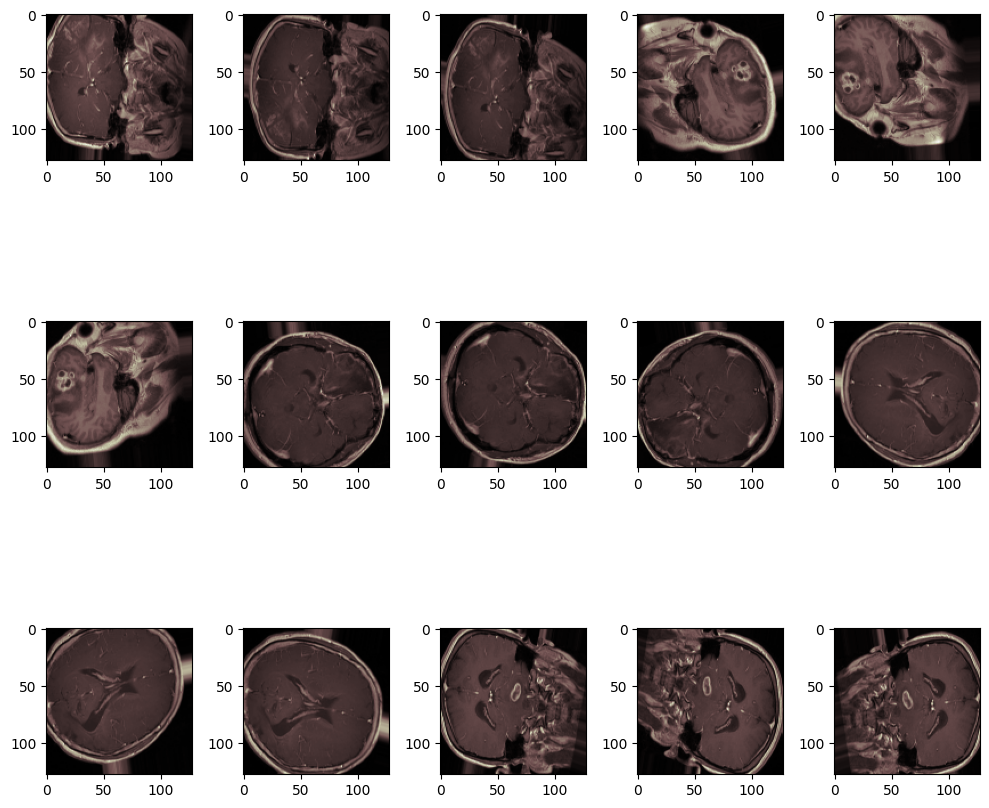

Epoch 1/50
262/264 [============================>.] - ETA: 0s - loss: 1.1062 - accuracy: 0.3916
Epoch 1: saving model to model-NeuroNet19.h5
Epoch 1: 11.14 seconds
264/264 [==============================] - 11s 38ms/step - loss: 1.1059 - accuracy: 0.3924 - val_loss: 1.3387 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.8434 - accuracy: 0.5662
Epoch 2: saving model to model-NeuroNet19.h5
Epoch 2: 9.72 seconds
264/264 [==============================] - 10s 37ms/step - loss: 0.8430 - accuracy: 0.5665 - val_loss: 1.2868 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.6738 - accuracy: 0.6676
Epoch 3: saving model to model-NeuroNet19.h5
Epoch 3: 9.69 seconds
264/264 [==============================] - 10s 37ms/step - loss: 0.6743 - accuracy: 0.6675 - val_loss: 0.5703 - val_accuracy: 0.8245 - lr: 1.0000e-04
Epoch 4/50
263/264 [============================>.] 

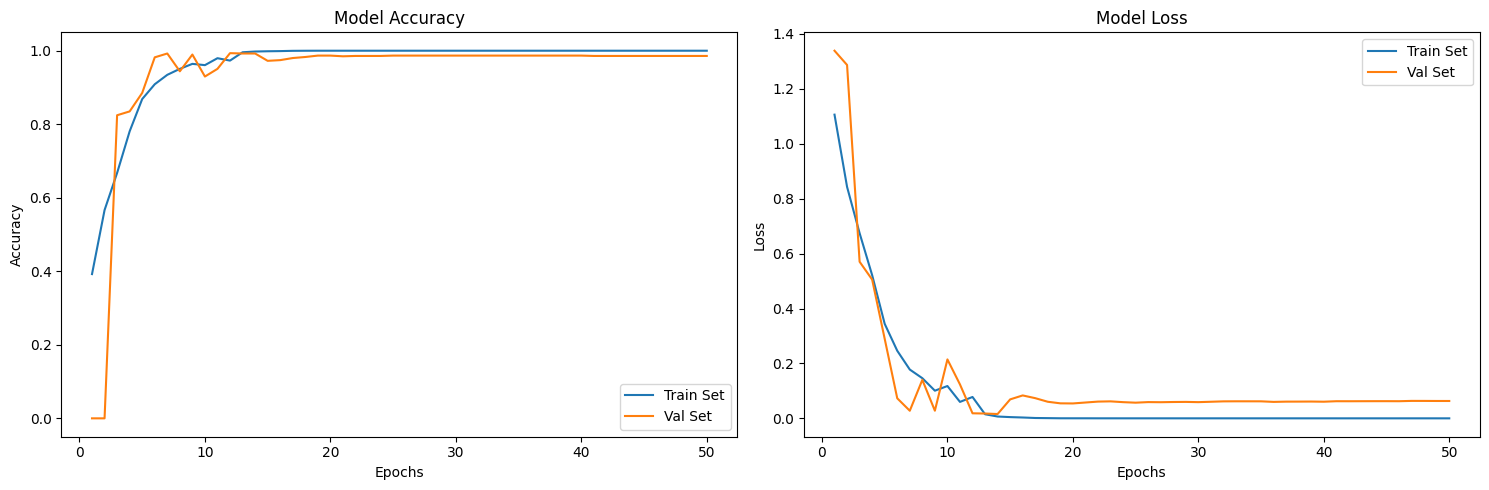

20/20 [==============================] - 0s 10ms/step - loss: 0.3098 - accuracy: 0.9430
Test Accuracy:  94.3
              precision    recall  f1-score   support

      glioma     0.9426    0.9755    0.9588       286
  meningioma     0.9085    0.9085    0.9085       142
   pituitary     0.9716    0.9194    0.9448       186

    accuracy                         0.9430       614
   macro avg     0.9409    0.9344    0.9373       614
weighted avg     0.9435    0.9430    0.9429       614



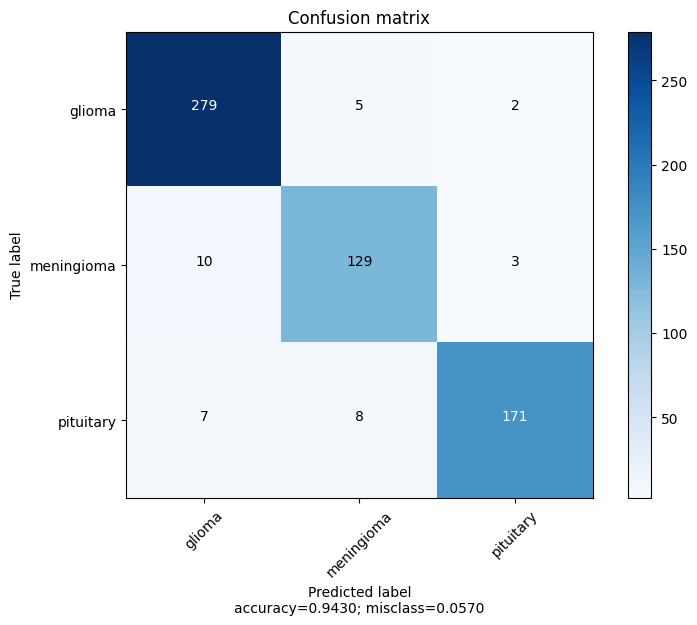

In [3]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 128
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
a = UpSampling2D(size=(6, 6))(model)
a = MaxPooling2D(pool_size=(6, 6))(a)
a = Conv2D(128, 1, padding='same')(a)

b = UpSampling2D(size=(4, 4))(model)
b = MaxPooling2D(pool_size=(4, 4))(b)
b = Conv2D(128, 1, padding='same')(b)

c = UpSampling2D(size=(3, 3))(model)
c = MaxPooling2D(pool_size=(3, 3))(c)
c = Conv2D(128, 1, padding='same')(c)

d = UpSampling2D(size=(2, 2))(model)
d = MaxPooling2D(pool_size=(2, 2))(d)
d = Conv2D(128, 1, padding='same')(d)

model =  Concatenate()([a, b, c, d])
model = Conv2D(256, 1, padding='same')(model)
model = Conv2D(128, 1, padding='same')(model)
                              
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-NeuroNet19.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f

100%|██████████| 186/186 [00:00<00:00, 194.44it/s]


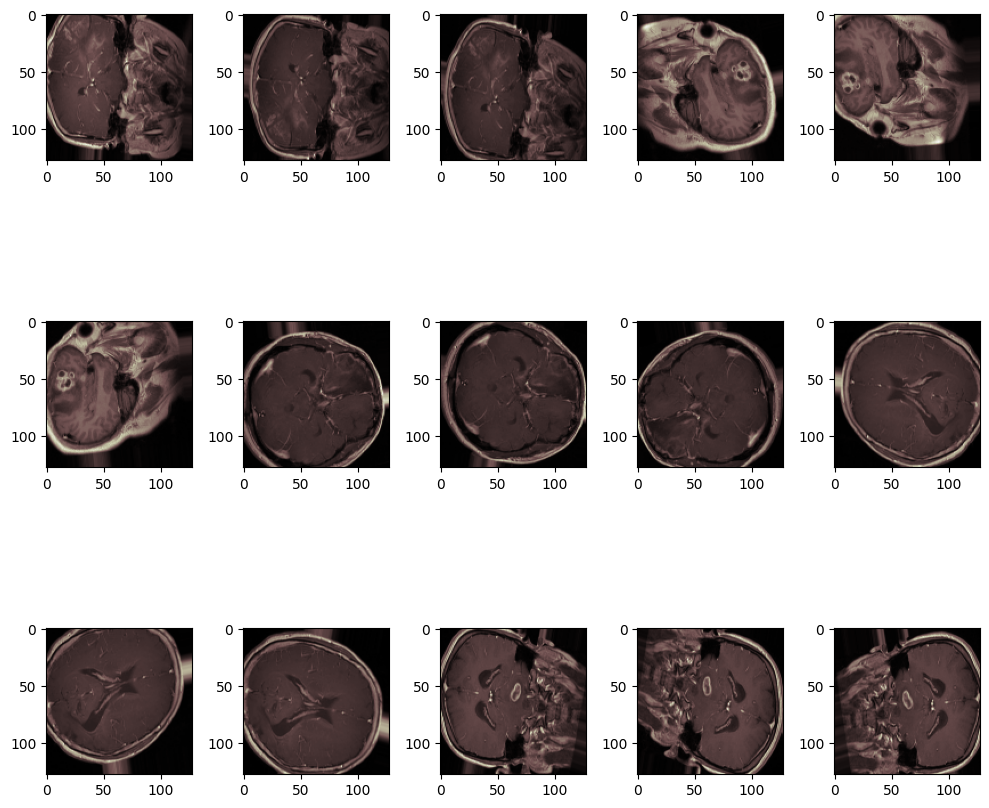

2024-03-15 08:31:20.280515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 08:31:20.617789: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:41:00.0, compute capability: 8.9


Epoch 1/50


2024-03-15 08:31:25.270620: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2024-03-15 08:31:26.125097: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-15 08:31:26.125122: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-15 08:31:26.125237: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-15 08:31:26.776550: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 1.1039 - accuracy: 0.3590
Epoch 1: saving model to model-NeuroNet19.h5
Epoch 1: 14.96 seconds
264/264 [==============================] - 15s 40ms/step - loss: 1.1039 - accuracy: 0.3590 - val_loss: 1.2346 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 1.0123 - accuracy: 0.4368
Epoch 2: saving model to model-NeuroNet19.h5
Epoch 2: 9.66 seconds
264/264 [==============================] - 10s 37ms/step - loss: 1.0121 - accuracy: 0.4369 - val_loss: 1.2880 - val_accuracy: 0.4658 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.8350 - accuracy: 0.5647
Epoch 3: saving model to model-NeuroNet19.h5
Epoch 3: 9.66 seconds
264/264 [==============================] - 10s 37ms/step - loss: 0.8346 - accuracy: 0.5649 - val_loss: 0.7576 - val_accuracy: 0.7201 - lr: 1.0000e-04
Epoch 4/50
263/264 [============================>.] - ETA: 0s - los

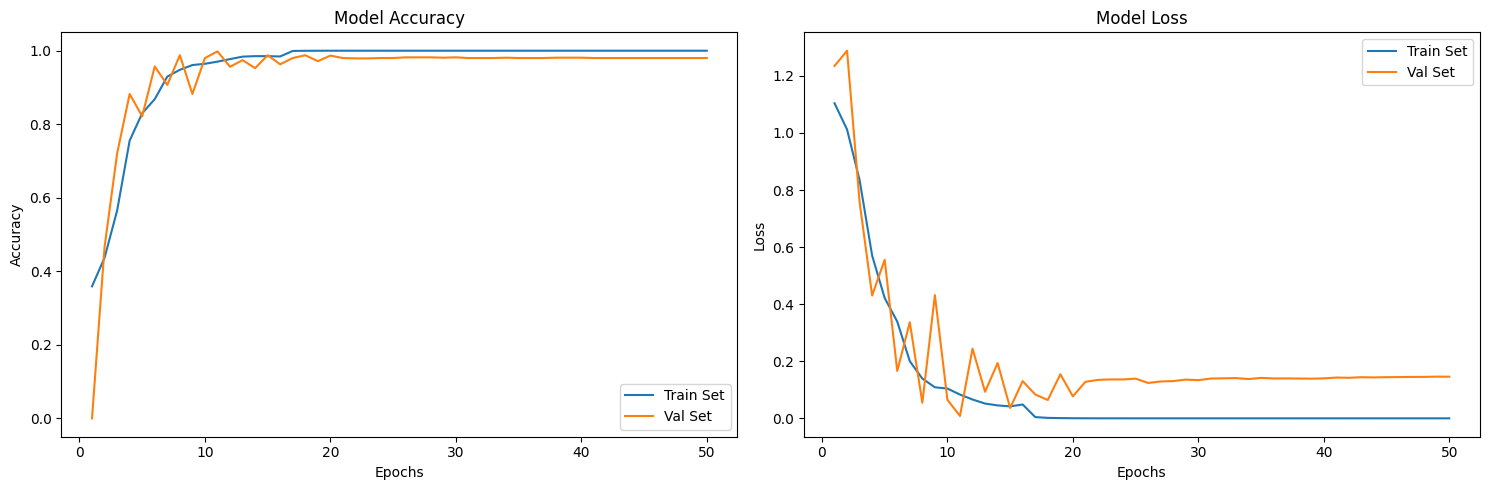

20/20 [==============================] - 0s 11ms/step - loss: 0.3759 - accuracy: 0.9511
Test Accuracy:  95.11
              precision    recall  f1-score   support

      glioma     0.9622    0.9790    0.9705       286
  meningioma     0.9091    0.9155    0.9123       142
   pituitary     0.9667    0.9355    0.9508       186

    accuracy                         0.9511       614
   macro avg     0.9460    0.9433    0.9445       614
weighted avg     0.9513    0.9511    0.9511       614



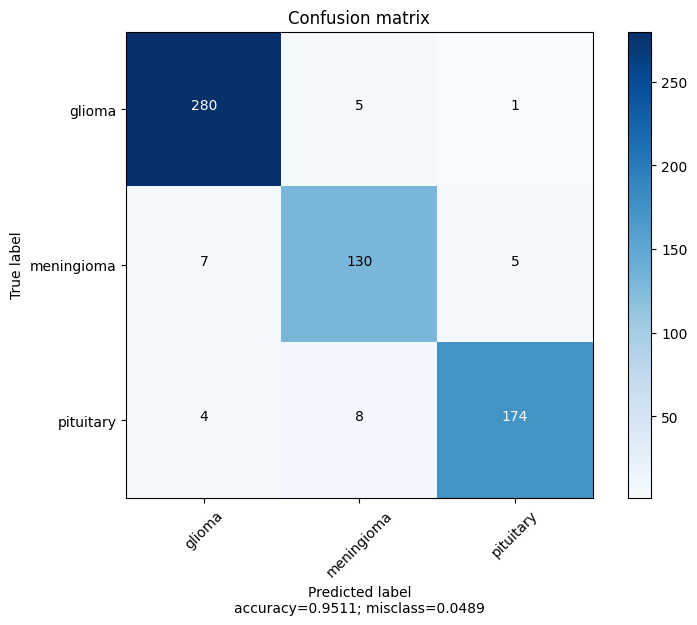

In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 128
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
a = UpSampling2D(size=(6, 6))(model)
a = MaxPooling2D(pool_size=(6, 6))(a)
a = Conv2D(128, 1, padding='same')(a)

b = UpSampling2D(size=(4, 4))(model)
b = MaxPooling2D(pool_size=(4, 4))(b)
b = Conv2D(128, 1, padding='same')(b)

c = UpSampling2D(size=(3, 3))(model)
c = MaxPooling2D(pool_size=(3, 3))(c)
c = Conv2D(128, 1, padding='same')(c)

d = UpSampling2D(size=(2, 2))(model)
d = MaxPooling2D(pool_size=(2, 2))(d)
d = Conv2D(128, 1, padding='same')(d)

model =  Concatenate()([a, b, c, d])
model = Conv2D(256, 1, padding='same')(model)
model = Conv2D(128, 1, padding='same')(model)
                              
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-NeuroNet19.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f

100%|██████████| 186/186 [00:00<00:00, 192.16it/s]


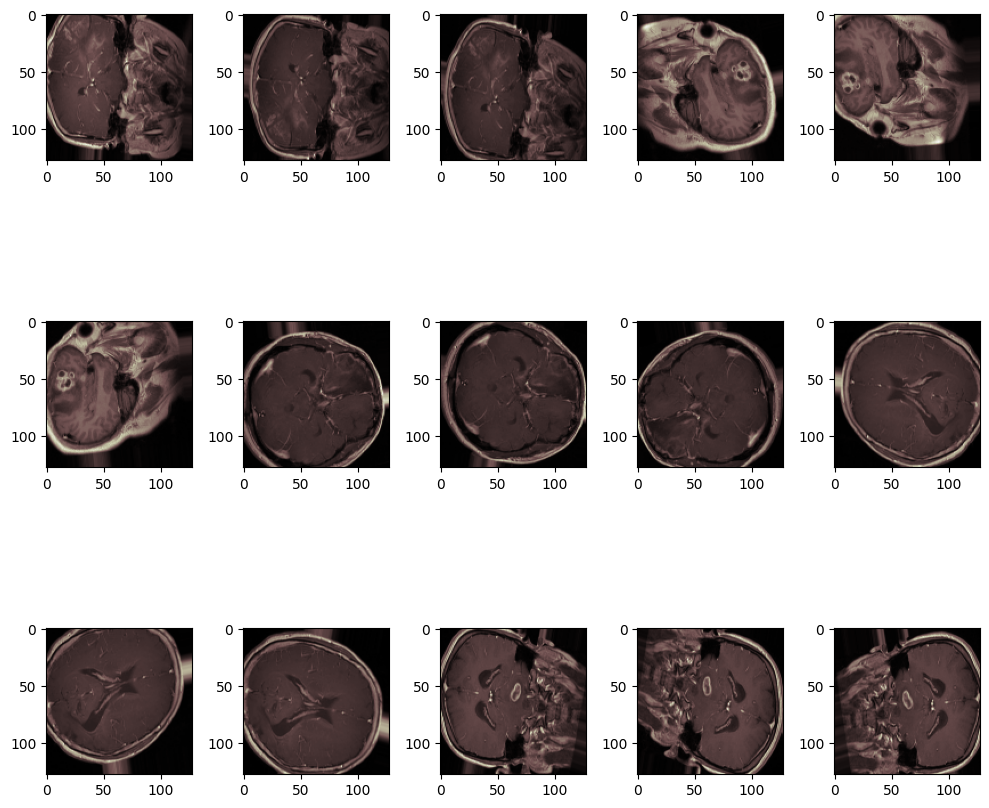

Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 0.8092 - accuracy: 0.6296
Epoch 1: saving model to model-NeuroNet19.h5
Epoch 1: 10.62 seconds
264/264 [==============================] - 11s 37ms/step - loss: 0.8086 - accuracy: 0.6299 - val_loss: 0.0529 - val_accuracy: 0.9934 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.3863 - accuracy: 0.8479
Epoch 2: saving model to model-NeuroNet19.h5
Epoch 2: 9.61 seconds
264/264 [==============================] - 10s 36ms/step - loss: 0.3862 - accuracy: 0.8479 - val_loss: 0.3113 - val_accuracy: 0.8985 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.2191 - accuracy: 0.9153
Epoch 3: saving model to model-NeuroNet19.h5
Epoch 3: 9.65 seconds
264/264 [==============================] - 10s 37ms/step - loss: 0.2191 - accuracy: 0.9153 - val_loss: 0.0777 - val_accuracy: 0.9725 - lr: 1.0000e-04
Epoch 4/50
263/264 [============================>.] - ETA: 0

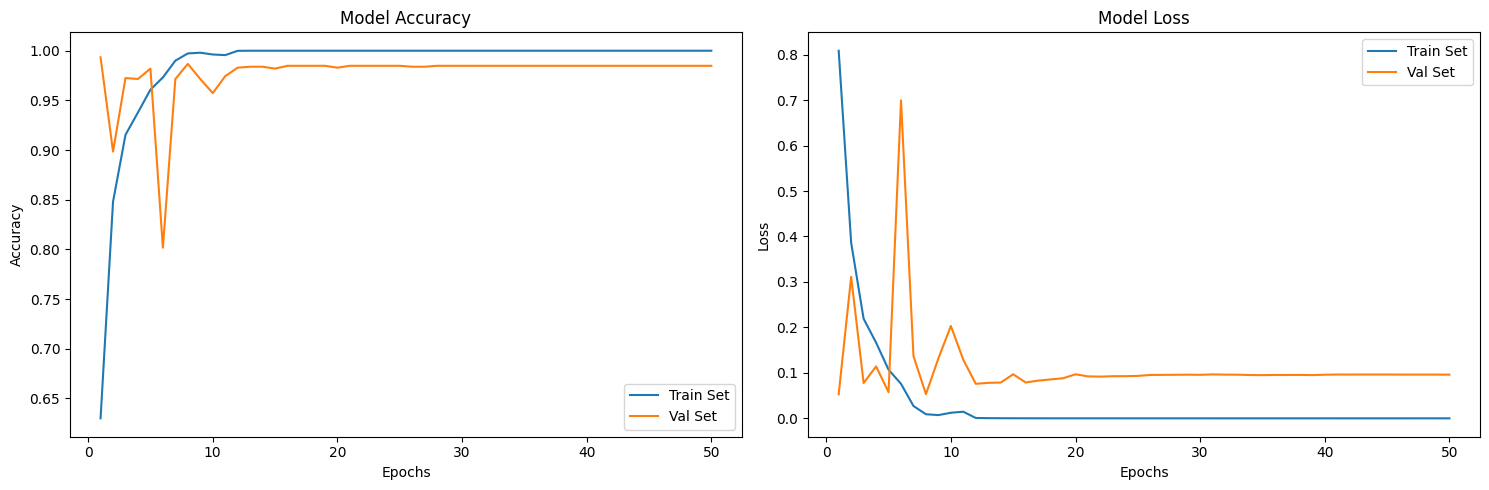

20/20 [==============================] - 0s 11ms/step - loss: 0.1872 - accuracy: 0.9625
Test Accuracy:  96.25
              precision    recall  f1-score   support

      glioma     0.9527    0.9860    0.9691       286
  meningioma     0.9638    0.9366    0.9500       142
   pituitary     0.9778    0.9462    0.9617       186

    accuracy                         0.9625       614
   macro avg     0.9647    0.9563    0.9603       614
weighted avg     0.9629    0.9625    0.9624       614



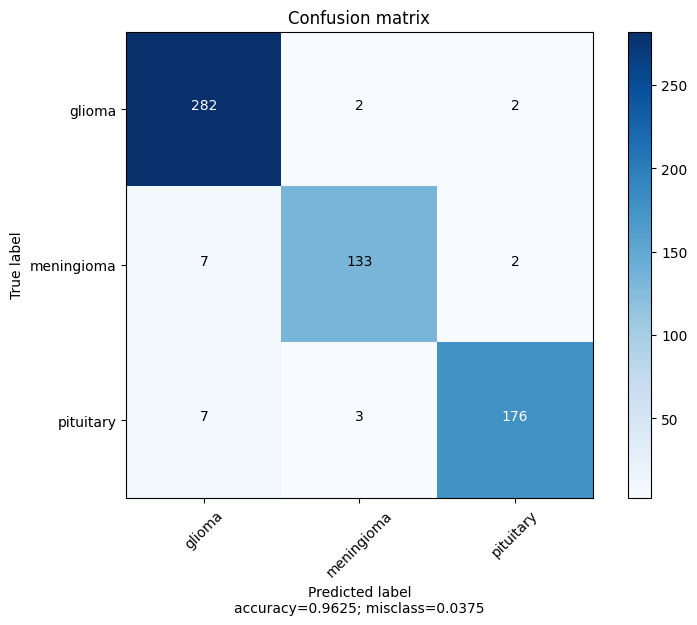

In [5]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 128
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
a = UpSampling2D(size=(6, 6))(model)
a = MaxPooling2D(pool_size=(6, 6))(a)
a = Conv2D(128, 1, padding='same')(a)

b = UpSampling2D(size=(4, 4))(model)
b = MaxPooling2D(pool_size=(4, 4))(b)
b = Conv2D(128, 1, padding='same')(b)

c = UpSampling2D(size=(3, 3))(model)
c = MaxPooling2D(pool_size=(3, 3))(c)
c = Conv2D(128, 1, padding='same')(c)

d = UpSampling2D(size=(2, 2))(model)
d = MaxPooling2D(pool_size=(2, 2))(d)
d = Conv2D(128, 1, padding='same')(d)

model =  Concatenate()([a, b, c, d])
model = Conv2D(256, 1, padding='same')(model)
model = Conv2D(128, 1, padding='same')(model)
                              
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-NeuroNet19.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f

100%|██████████| 186/186 [00:00<00:00, 197.17it/s]


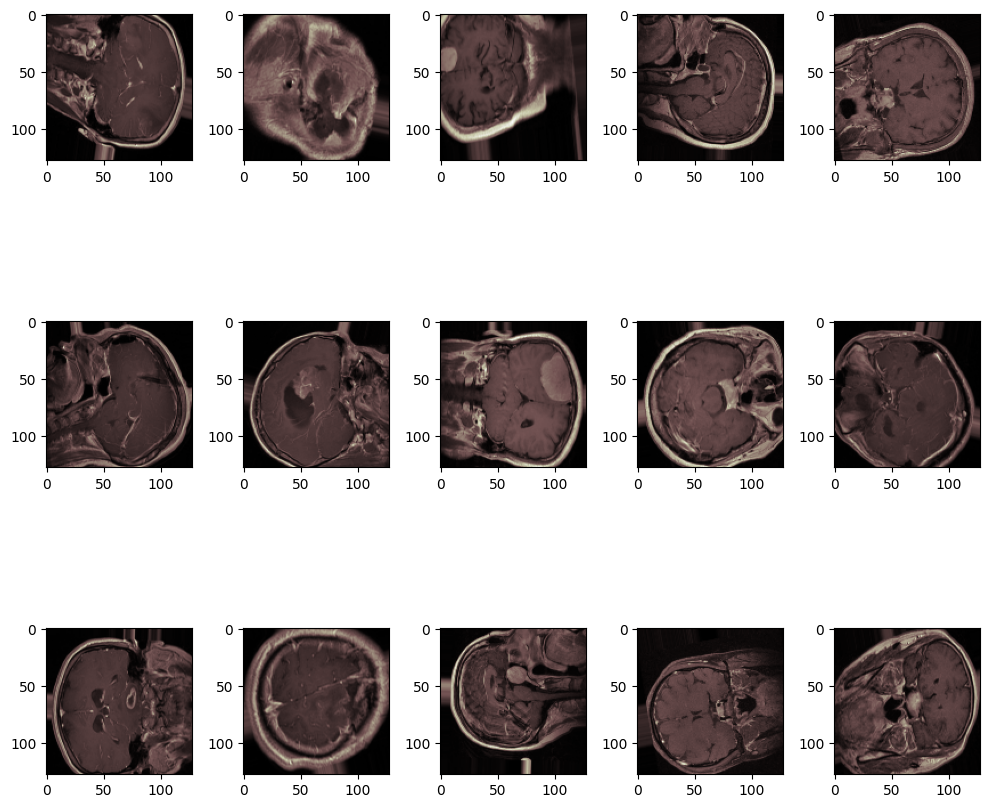

2024-03-15 10:22:58.927125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 10:22:59.249924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:41:00.0, compute capability: 8.9


Epoch 1/50


2024-03-15 10:23:03.771226: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2024-03-15 10:23:04.630397: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-15 10:23:04.630412: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-15 10:23:04.630487: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-15 10:23:05.276275: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 0.8585 - accuracy: 0.5663
Epoch 1: saving model to model-NeuroNet19.h5
Epoch 1: 14.96 seconds
264/264 [==============================] - 15s 41ms/step - loss: 0.8585 - accuracy: 0.5663 - val_loss: 0.6968 - val_accuracy: 0.6822 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.4764 - accuracy: 0.8087
Epoch 2: saving model to model-NeuroNet19.h5
Epoch 2: 9.71 seconds
264/264 [==============================] - 10s 37ms/step - loss: 0.4763 - accuracy: 0.8087 - val_loss: 0.5239 - val_accuracy: 0.7571 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.3628 - accuracy: 0.8591
Epoch 3: saving model to model-NeuroNet19.h5
Epoch 3: 9.56 seconds
264/264 [==============================] - 10s 36ms/step - loss: 0.3627 - accuracy: 0.8591 - val_loss: 0.2192 - val_accuracy: 0.9175 - lr: 1.0000e-04
Epoch 4/50
263/264 [============================>.] - ETA: 0s - loss: 0

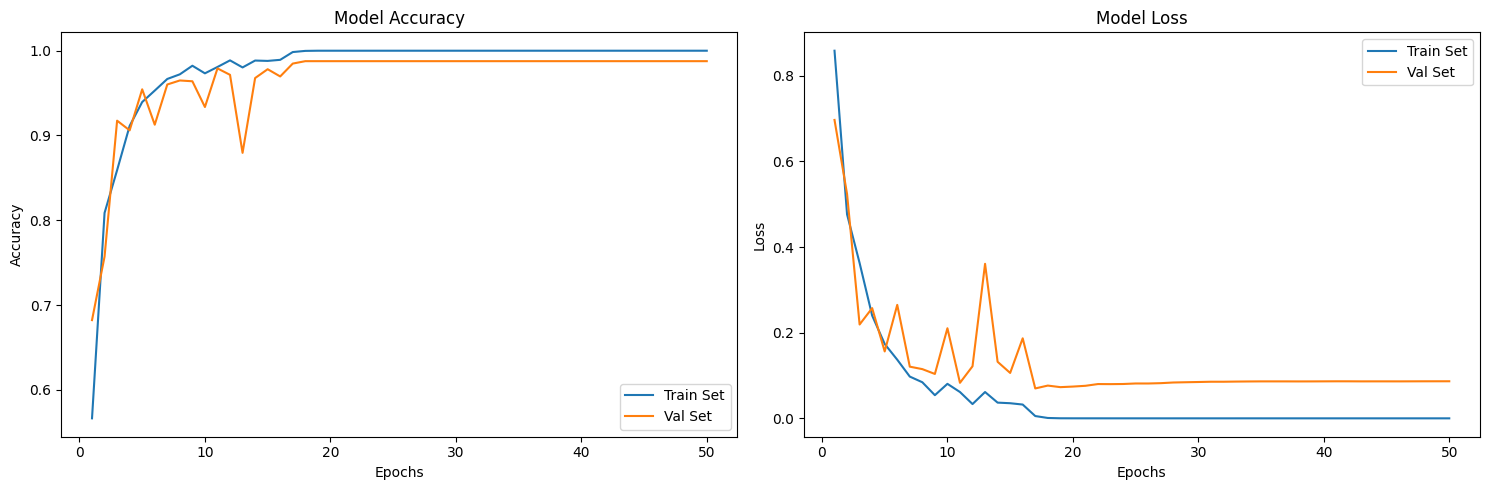

20/20 [==============================] - 0s 11ms/step - loss: 0.1445 - accuracy: 0.9691
Test Accuracy:  96.91
              precision    recall  f1-score   support

      glioma     0.9623    0.9825    0.9723       286
  meningioma     0.9779    0.9366    0.9568       142
   pituitary     0.9731    0.9731    0.9731       186

    accuracy                         0.9691       614
   macro avg     0.9711    0.9641    0.9674       614
weighted avg     0.9692    0.9691    0.9690       614



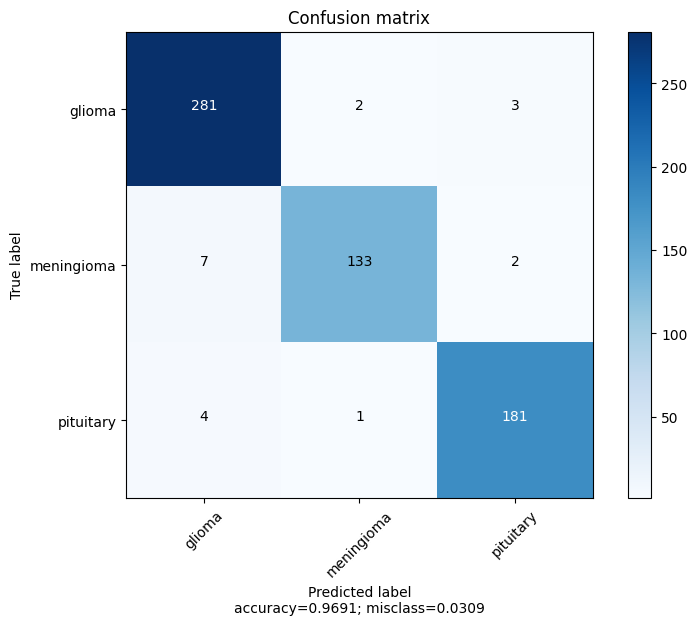

In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 128
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
a = UpSampling2D(size=(6, 6))(model)
a = MaxPooling2D(pool_size=(6, 6))(a)
a = Conv2D(128, 1, padding='same')(a)

b = UpSampling2D(size=(4, 4))(model)
b = MaxPooling2D(pool_size=(4, 4))(b)
b = Conv2D(128, 1, padding='same')(b)

c = UpSampling2D(size=(3, 3))(model)
c = MaxPooling2D(pool_size=(3, 3))(c)
c = Conv2D(128, 1, padding='same')(c)

d = UpSampling2D(size=(2, 2))(model)
d = MaxPooling2D(pool_size=(2, 2))(d)
d = Conv2D(128, 1, padding='same')(d)

model =  Concatenate()([a, b, c, d])
model = Conv2D(256, 1, padding='same')(model)
model = Conv2D(128, 1, padding='same')(model)
                              
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-NeuroNet19.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f